In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.feature_selection import SelectKBest, f_regression

In [209]:
data = pd.read_csv('/kaggle/input/airline/train.csv')
print(data.shape) #(45000, 19)
print(data.isnull().sum())
print(data.info())
print(data.describe())

(45000, 19)
Flight_ID                 0
Airline                3573
Departure_City          340
Arrival_City            186
Distance                 91
Departure_Time            0
Arrival_Time              0
Duration                  0
Aircraft_Type            43
Number_of_Stops           0
Day_of_Week             225
Month_of_Travel         267
Holiday_Season         9020
Demand                  317
Weather_Conditions      302
Passenger_Count           0
Promotion_Type        15215
Fuel_Price               90
Flight_Price              0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Flight_ID           45000 non-null  object 
 1   Airline             41427 non-null  object 
 2   Departure_City      44660 non-null  object 
 3   Arrival_City        44814 non-null  object 
 4   Distance            44909 non-null 

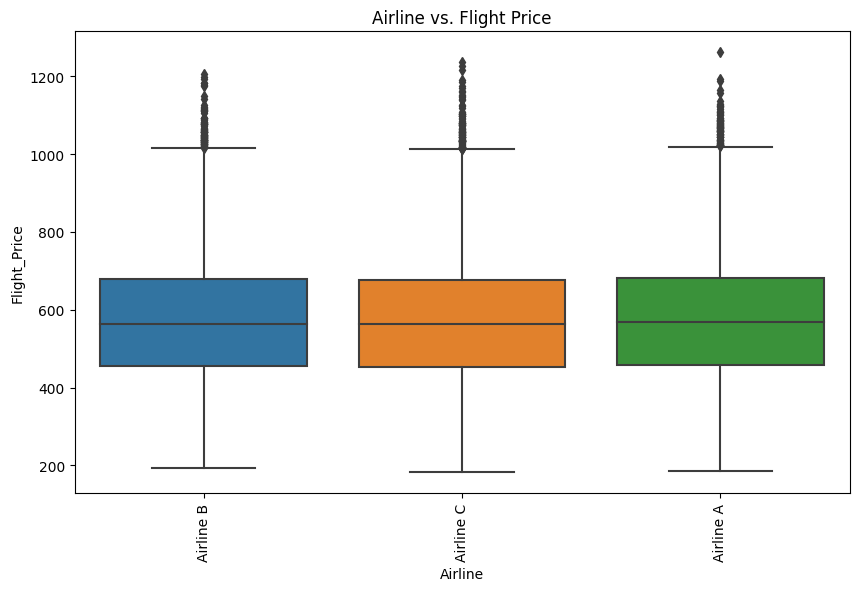

In [210]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Airline', y='Flight_Price')
plt.title('Airline vs. Flight Price')
plt.xticks(rotation=90)
plt.show()

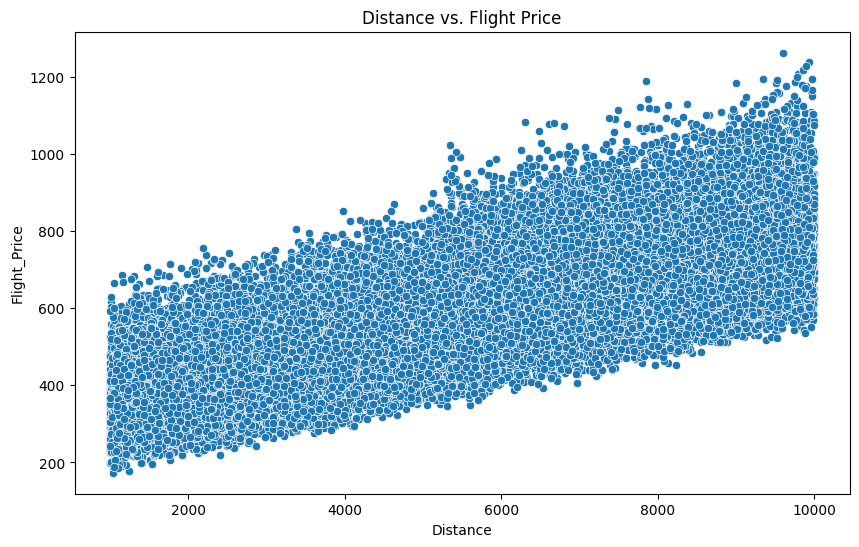

In [211]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Distance', y='Flight_Price')
plt.title('Distance vs. Flight Price')
plt.show()

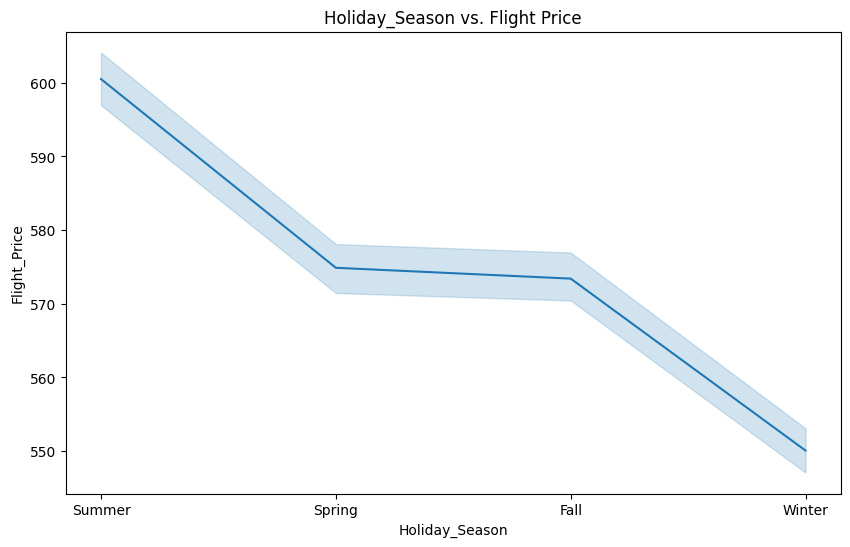

In [212]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='Holiday_Season', y='Flight_Price')
plt.title('Holiday_Season vs. Flight Price')
plt.show()

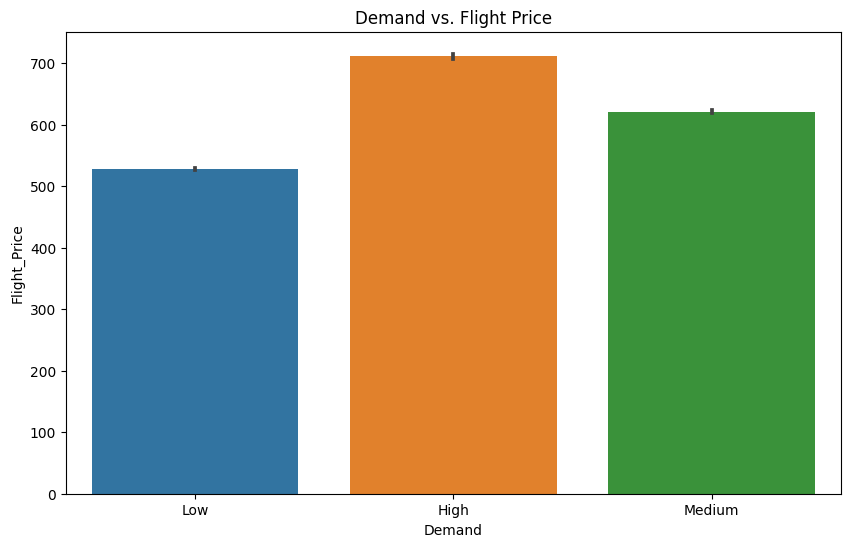

In [213]:
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='Demand', y='Flight_Price')
plt.title('Demand vs. Flight Price')
plt.show()

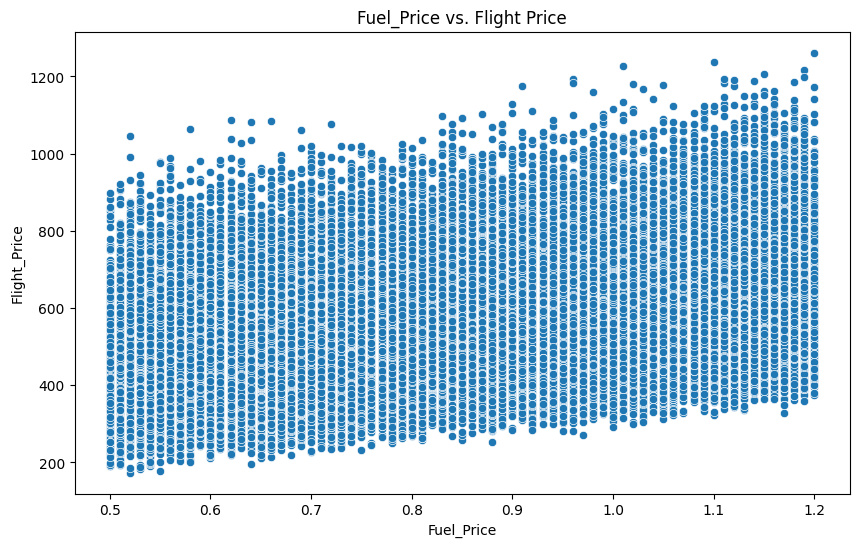

In [214]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Fuel_Price', y='Flight_Price')
plt.title('Fuel_Price vs. Flight Price')
plt.show()

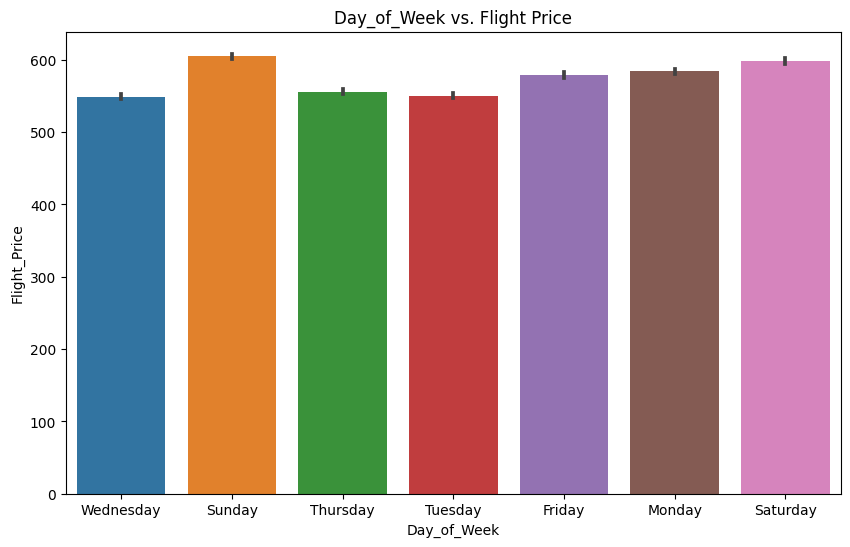

In [215]:
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='Day_of_Week', y='Flight_Price')
plt.title('Day_of_Week vs. Flight Price')
plt.show()

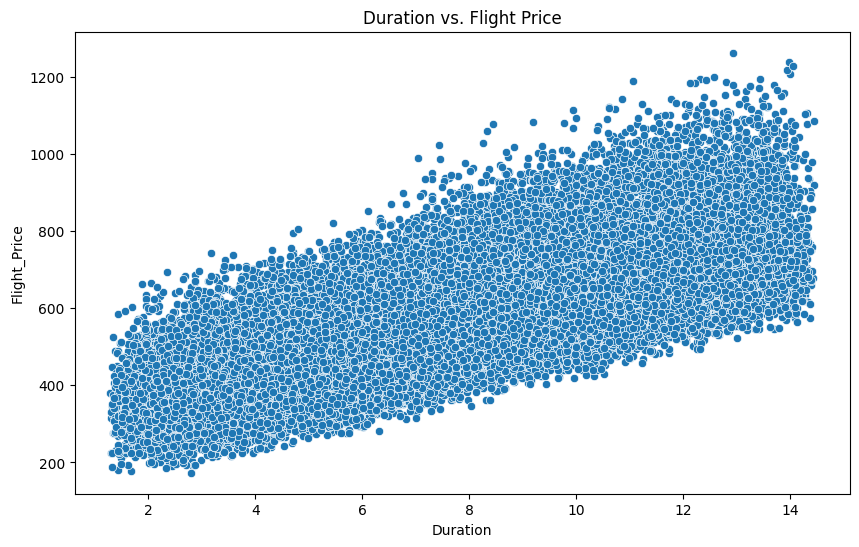

In [216]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Duration', y='Flight_Price')
plt.title('Duration vs. Flight Price')
plt.show()

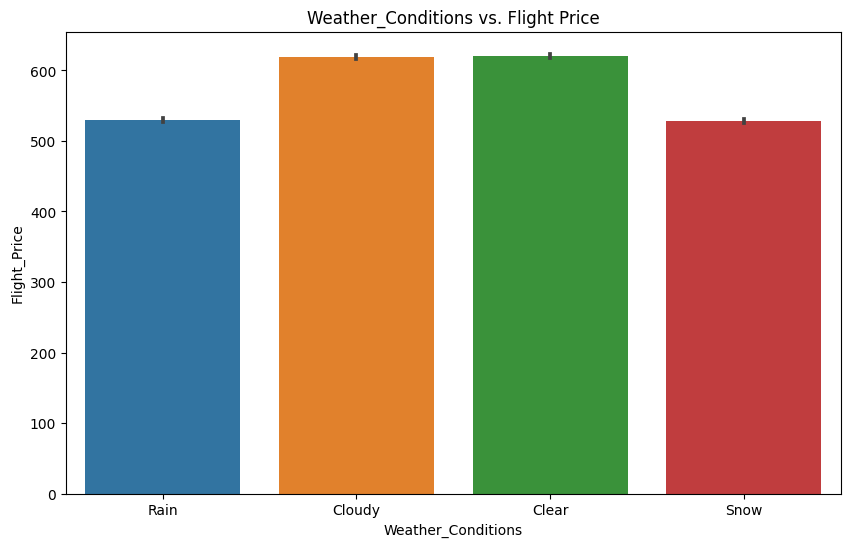

In [217]:
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='Weather_Conditions', y='Flight_Price')
plt.title('Weather_Conditions vs. Flight Price')
plt.show()

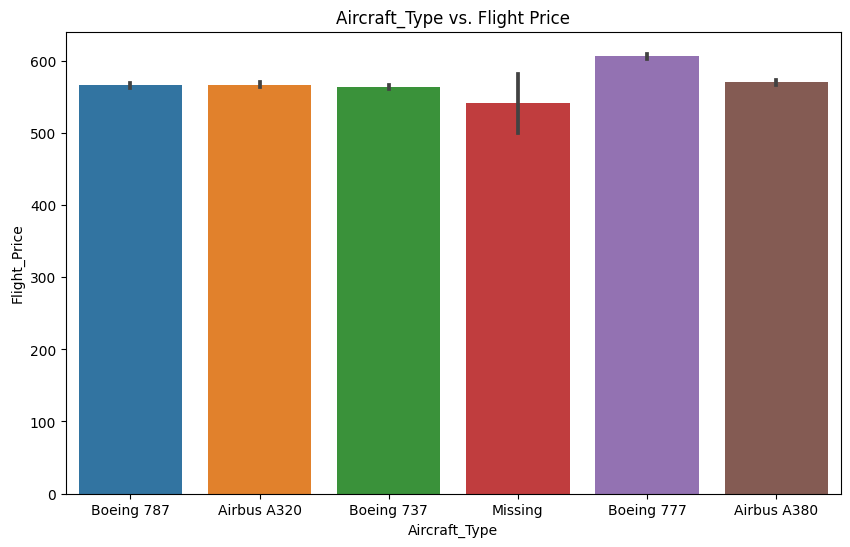

In [223]:
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='Aircraft_Type', y='Flight_Price')
plt.title('Aircraft_Type vs. Flight Price')
plt.show()

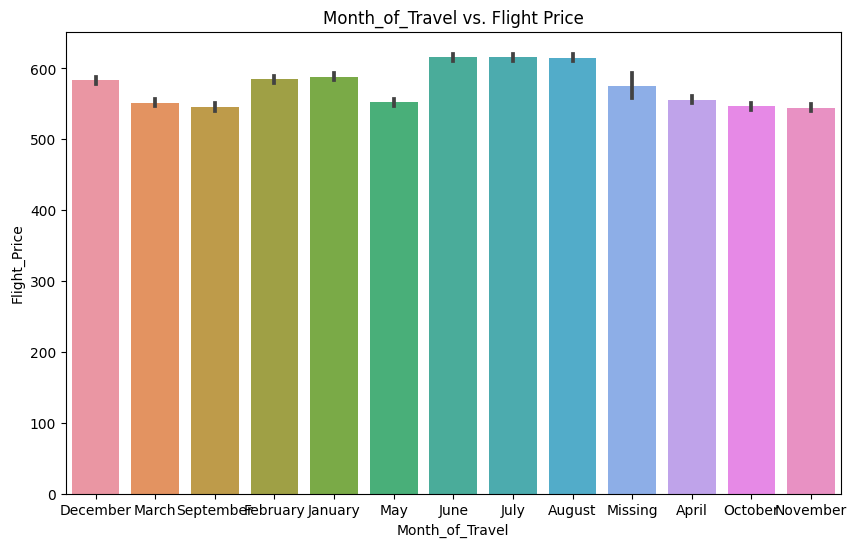

Month_of_Travel
April        555.872733
August       614.718354
December     583.230878
February     584.179225
January      587.835582
July         615.433742
June         615.314662
March        551.338747
May          551.961367
Missing      575.358352
November     544.408538
October      546.360855
September    545.684731
Name: Flight_Price, dtype: float64


In [227]:
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='Month_of_Travel', y='Flight_Price')
plt.title('Month_of_Travel vs. Flight Price')
plt.show()
print(data.groupby('Month_of_Travel')['Flight_Price'].mean())

In [219]:
# Handle missing values
categorical_columns = ['Airline', 'Departure_City', 'Arrival_City', 'Demand', 'Promotion_Type', 'Aircraft_Type', 'Day_of_Week', 'Month_of_Travel','Holiday_Season','Weather_Conditions']

for column in categorical_columns:
    data[column].fillna('Missing', inplace=True)

numerical_columns = ['Distance', 'Fuel_Price']

for column in numerical_columns:
    data[column].fillna(data[column].median(), inplace=True)

data.isnull().sum()

Flight_ID             0
Airline               0
Departure_City        0
Arrival_City          0
Distance              0
Departure_Time        0
Arrival_Time          0
Duration              0
Aircraft_Type         0
Number_of_Stops       0
Day_of_Week           0
Month_of_Travel       0
Holiday_Season        0
Demand                0
Weather_Conditions    0
Passenger_Count       0
Promotion_Type        0
Fuel_Price            0
Flight_Price          0
dtype: int64

In [220]:
# Combine 'Departure_City' and 'Arrival_City' to create a set of unique cities
unique_cities = set(data['Departure_City'].unique()) | set(data['Arrival_City'].unique())

# Create a mapping dictionary where each unique city is assigned a unique integer label
city_mapping = {city: label for label, city in enumerate(unique_cities)}

# Apply the mapping to both 'Departure_City' and 'Arrival_City'
data['Departure_City'] = data['Departure_City'].map(city_mapping)
data['Arrival_City'] = data['Arrival_City'].map(city_mapping)

data.head()

,Flight_ID,Airline,Departure_City,Arrival_City,Distance,Departure_Time,Arrival_Time,Duration,Aircraft_Type,Number_of_Stops,Day_of_Week,Month_of_Travel,Holiday_Season,Demand,Weather_Conditions,Passenger_Count,Promotion_Type,Fuel_Price,Flight_Price
0,F1,Airline B,10181,4398,8286.0,8:23,20:19,11.94,Boeing 787,0,Wednesday,December,Summer,Low,Rain,240,Special Offer,0.91,643.93
1,F2,Airline C,508,5574,2942.0,20:28,1:45,5.29,Airbus A320,0,Wednesday,March,Spring,Low,Rain,107,Missing,1.08,423.13
2,F3,Airline B,14004,618,2468.0,11:30,15:54,4.41,Boeing 787,1,Sunday,September,Summer,High,Cloudy,131,Missing,0.52,442.17
3,F4,Missing,19526,16284,3145.0,20:24,1:21,4.96,Boeing 787,0,Sunday,February,Fall,Low,Cloudy,170,Discount,0.71,394.42
4,F5,Airline B,4294,20907,5558.0,21:59,6:04,8.09,Boeing 737,1,Thursday,January,Missing,Missing,Clear,181,Missing,1.09,804.35


In [222]:
print(data['Airline'].unique())
print(data['Aircraft_Type'].unique())
print(data['Day_of_Week'].unique())
print(data['Month_of_Travel'].unique())
print(data['Holiday_Season'].unique())
print(data['Demand'].unique())
print(data['Weather_Conditions'].unique())
print(data['Promotion_Type'].unique())

['Airline B' 'Airline C' 'Missing' 'Airline A']
['Boeing 787' 'Airbus A320' 'Boeing 737' 'Missing' 'Boeing 777'
 'Airbus A380']
['Wednesday' 'Sunday' 'Thursday' 'Tuesday' 'Friday' 'Monday' 'Saturday'
 'Missing']
['December' 'March' 'September' 'February' 'January' 'May' 'June' 'July'
 'August' 'Missing' 'April' 'October' 'November']
['Summer' 'Spring' 'Fall' 'Missing' 'Winter']
['Low' 'High' 'Missing' 'Medium']
['Rain' 'Cloudy' 'Clear' 'Snow' 'Missing']
['Special Offer' 'Missing' 'Discount']


In [178]:
# Extract hour of departure and arrival from 'Departure_Time' and 'Arrival_Time'
# Convert 'Departure_Time' and 'Arrival_Time' to datetime objects
data['Departure_Time'] = pd.to_datetime(data['Departure_Time'])
data['Arrival_Time'] = pd.to_datetime(data['Arrival_Time'])

# Extract hour and minute features from 'Departure_Time' and 'Arrival_Time'
data['Departure_Hour'] = data['Departure_Time'].dt.hour
data['Departure_Minute'] = data['Departure_Time'].dt.minute
data['Arrival_Hour'] = data['Arrival_Time'].dt.hour
data['Arrival_Minute'] = data['Arrival_Time'].dt.minute

# Drop the original 'Departure_Time' and 'Arrival_Time' columns
data.drop(['Departure_Time', 'Arrival_Time'], axis=1, inplace=True)

data = pd.get_dummies(data, columns=['Airline', 'Aircraft_Type', 'Day_of_Week', 'Month_of_Travel', 'Holiday_Season', 'Weather_Conditions', 'Promotion_Type'])


ordinal_encoding = {
    'Demand': {'Low': 1, 'Medium': 2, 'High': 3, 'Missing':0},
    'Holiday_Season': {'Winter': 1, 'Spring': 3, 'Summer': 4, 'Fall': 2, 'Missing': 0},
    
}

# Apply ordinal encoding to the dataset
for column, encoding_map in ordinal_encoding.items():
    data[column] = data[column].map(encoding_map).astype(int)

/tmp/ipykernel_28/1926513210.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Departure_Time'] = pd.to_datetime(data['Departure_Time'])
/tmp/ipykernel_28/1926513210.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Arrival_Time'] = pd.to_datetime(data['Arrival_Time'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Flight_ID               45000 non-null  int64  
 1   Departure_City          45000 non-null  int64  
 2   Arrival_City            45000 non-null  int64  
 3   Distance                45000 non-null  float64
 4   Duration                45000 non-null  float64
 5   Aircraft_Type           45000 non-null  int64  
 6   Number_of_Stops         45000 non-null  float64
 7   Day_of_Week             45000 non-null  int64  
 8   Month_of_Travel         45000 non-null  int64  
 9   Holiday_Season          45000 non-null  int64  
 10  Demand                  45000 non-null  int64  
 11  Weather_Conditions      45000 non-null  int64  
 12  Passenger_Count         45000 non-null  float64
 13  Promotion_Type          45000 non-null  int64  
 14  Fuel_Price              45000 non-null

In [ ]:
# Convert categorical variables to numerical using label encoding
label_encoders = {}
categorical_columns = ['Aircraft_Type', 'Day_of_Week', 'Month_of_Travel', 'Demand','Holiday_Season', 'Weather_Conditions', 'Promotion_Type']

data = pd.get_dummies(data, columns=['Airline'], drop_first=True)

for column in categorical_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Scaling/Normalizing numerical features
scaler = StandardScaler()
numeric_columns = ['Distance', 'Duration', 'Number_of_Stops', 'Fuel_Price', 'Passenger_Count']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
data.info()

In [179]:
data.head()

,Flight_ID,Departure_City,Arrival_City,Distance,Duration,Aircraft_Type,Number_of_Stops,Day_of_Week,Month_of_Travel,Holiday_Season,...,Fuel_Price,Flight_Price,Promotion_Type_Missing,Departure_Hour,Departure_Minute,Arrival_Hour,Arrival_Minute,Airline_Airline B,Airline_Airline C,Airline_Missing
0,1,10181,4398,1.081622,1.241312,4,-0.886882,7,2,3,...,0.296768,643.93,0,8,23,20,19,True,False,False
1,2,508,5574,-0.979952,-0.778220,0,-0.886882,7,7,2,...,1.140305,423.13,1,20,28,1,45,False,True,False
2,3,14004,618,-1.162809,-1.045466,4,0.445440,4,12,3,...,-1.638404,442.17,1,11,30,15,54,True,False,False
3,4,19526,16284,-0.901640,-0.878437,4,-0.886882,4,3,0,...,-0.695628,394.42,0,20,24,1,21,False,False,True
4,5,4294,20907,0.029232,0.072109,2,0.445440,5,4,1,...,1.189925,804.35,1,21,59,6,4,True,False,False


In [180]:
# Feature Selection using SelectKBest and f_regression
X = data.drop(['Flight_Price'], axis=1)
y = data['Flight_Price']

selector = SelectKBest(score_func=f_regression, k=10)  # You can adjust 'k' as needed
X_selected = selector.fit_transform(X, y)
selected_feature_indices = selector.get_support(indices=True)

# Get the names of selected features
selected_features = X.columns[selected_feature_indices]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.3, random_state=42)

# Initialize and train the XGBoost Regressor model
xgb_regressor = XGBRegressor()
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}
scorer = make_scorer(mean_absolute_error, greater_is_better=False)
random_search = RandomizedSearchCV(
    xgb_regressor,
    param_distributions=param_grid,
    scoring=scorer,
    cv=5,  # You can adjust the number of cross-validation folds
    n_iter=50,  # Adjust the number of iterations as needed
    verbose=0,  # Increase verbosity for progress updates
    n_jobs=-1,  # Utilize all available CPU cores
    random_state=42,  # Set a random seed for reproducibility
)

# Fit the random search to the data
random_search.fit(X_train, y_train)

best_xgb_model = random_search.best_estimator_
best_hyperparameters = random_search.best_params_

print(best_xgb_model)
print(best_hyperparameters)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
{'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}


In [181]:
selected_features

Index(['Distance', 'Duration', 'Aircraft_Type', 'Number_of_Stops',
       'Day_of_Week', 'Month_of_Travel', 'Holiday_Season', 'Demand',
       'Weather_Conditions', 'Fuel_Price'],
      dtype='object')

In [182]:
y_pred = best_xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Best Model MAE: {mae}')
print(f'Best Model RMSE: {rmse}')

Best Model MAE: 9.882022851336444
Best Model RMSE: 13.285556203661988


In [183]:
test = pd.read_csv("/kaggle/input/airline/test.csv")

# Handle missing values
categorical_columns = ['Airline', 'Departure_City', 'Arrival_City', 'Demand', 'Aircraft_Type', 'Day_of_Week', 'Month_of_Travel','Holiday_Season','Weather_Conditions']

for column in categorical_columns:
    test[column].fillna('Missing', inplace=True)

numerical_columns = ['Distance', 'Fuel_Price']

for column in numerical_columns:
    test[column].fillna(test[column].median(), inplace=True)

data['Promotion_Type_Missing'] = test['Promotion_Type'].isnull().astype(int)

data['Fuel_Price'].fillna(test['Fuel_Price'].median(), inplace=True)

unique_cities = set(test['Departure_City'].unique()) | set(test['Arrival_City'].unique())
city_mapping = {city: label for label, city in enumerate(unique_cities)}
test['Departure_City'] = test['Departure_City'].map(city_mapping)
test['Arrival_City'] = test['Arrival_City'].map(city_mapping)

# Extract hour of departure and arrival from 'Departure_Time' and 'Arrival_Time'
# Convert 'Departure_Time' and 'Arrival_Time' to datetime objects
test['Departure_Time'] = pd.to_datetime(test['Departure_Time'])
test['Arrival_Time'] = pd.to_datetime(test['Arrival_Time'])

# Extract hour and minute features from 'Departure_Time' and 'Arrival_Time'
test['Departure_Hour'] = test['Departure_Time'].dt.hour
test['Departure_Minute'] = test['Departure_Time'].dt.minute
test['Arrival_Hour'] = test['Arrival_Time'].dt.hour
test['Arrival_Minute'] = test['Arrival_Time'].dt.minute

# Drop the original 'Departure_Time' and 'Arrival_Time' columns
test.drop(['Departure_Time', 'Arrival_Time'], axis=1, inplace=True)

# Convert categorical variables to numerical using label encoding
label_encoders = {}
categorical_columns = ['Aircraft_Type', 'Day_of_Week', 'Month_of_Travel', 'Demand','Holiday_Season', 'Weather_Conditions', 'Promotion_Type']

test = pd.get_dummies(test, columns=['Airline'], drop_first=True)

for column in categorical_columns:
    le = LabelEncoder()
    test[column] = le.fit_transform(test[column])
    label_encoders[column] = le

# Scaling/Normalizing numerical features
scaler = StandardScaler()
numeric_columns = ['Distance', 'Duration', 'Number_of_Stops', 'Fuel_Price', 'Passenger_Count']
test[numeric_columns] = scaler.fit_transform(test[numeric_columns])
test_X = test[['Distance', 'Duration', 'Aircraft_Type', 'Number_of_Stops',
       'Day_of_Week', 'Month_of_Travel', 'Holiday_Season', 'Demand',
       'Weather_Conditions', 'Fuel_Price']]
test.head()

/tmp/ipykernel_28/1861007639.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test['Departure_Time'] = pd.to_datetime(test['Departure_Time'])
/tmp/ipykernel_28/1861007639.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test['Arrival_Time'] = pd.to_datetime(test['Arrival_Time'])


,Flight_ID,Departure_City,Arrival_City,Distance,Duration,Aircraft_Type,Number_of_Stops,Day_of_Week,Month_of_Travel,Holiday_Season,...,Passenger_Count,Promotion_Type,Fuel_Price,Departure_Hour,Departure_Minute,Arrival_Hour,Arrival_Minute,Airline_Airline B,Airline_Airline C,Airline_Missing
0,F45001,7130,6402,-0.904921,-0.695995,2,0.448898,3,1,3,...,-0.890900,2,0.486062,18,43,0,14,True,False,False
1,F45002,5112,197,1.262554,1.195769,1,0.448898,5,0,1,...,1.647034,0,0.978645,1,16,13,4,False,False,False
2,F45003,300,1599,0.346046,0.530037,3,0.448898,4,4,1,...,0.659297,0,-1.090205,12,17,21,52,False,True,False
3,F45004,1852,828,0.908962,0.716803,1,-0.901578,5,7,1,...,0.659297,2,0.141253,0,11,10,23,False,False,False
4,F45005,5841,4756,-1.657644,-1.798520,0,0.448898,3,1,3,...,-0.410750,1,1.274195,3,22,5,13,True,False,False


In [184]:
y_pred = best_xgb_model.predict(test_X)

# Create a DataFrame with 'Flight_ID' and 'Predicted_Price' columns
submission_df = pd.DataFrame({'Flight_ID': test.Flight_ID, 'Flight_Price': y_pred})

# Save the DataFrame to a CSV file
submission_df.to_csv('Submission.csv', index=False)

In [185]:
pd.read_csv("/kaggle/working/Submission.csv")

,Flight_ID,Flight_Price
0,F45001,629.34800
1,F45002,915.09700
2,F45003,571.77170
3,F45004,555.51700
4,F45005,660.58730
...,...,...
4995,F49996,779.73486
4996,F49997,533.04175
4997,F49998,350.06165
4998,F49999,737.98830
